In [1]:
import pandas as pd
import psycopg2
import traceback


class Conexion_BD:
    def __init__(self, host,port,name,user,password):
        self.host = host
        self.port = port
        self.name = name
        self.user = user
        self.password = password
        self.estado = "Correcto"
        self.conexion = ''
        self.Estado_Conexion = self.crear_conexion()

    def crear_conexion(self):
        cxn = True
        try:
            self.conexion = psycopg2.connect(
                host=self.host,
                port=self.port,
                database=self.name,
                user=self.user,
                password=self.password)
        except Exception as e:
            self.estado = f"Error de conexion: \nServer: {self.host}\nDATABASE: {self.name}"
            cxn = False
        return cxn

    def consultar_bd(self, consulta):
        df = None
        self.estado = "Correcto"
        try:
            cursor = self.conexion.cursor()
            cursor.execute(consulta)
            records = cursor.fetchall()
            columnas = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(records, columns=columnas)
            cursor.close()
        except Exception as e:
            self.estado = f"Error en consulta: {traceback.format_exc()}"
        return df

    def cerrar_conexion(self):
        self.conexion.close()        
        self.Estado_Conexion = False


In [2]:
db_host = 'database-iot-pry20241050.clguogmy6dz7.us-east-2.rds.amazonaws.com'
db_port = 5432
db_name = 'iotdatabase'
db_user = 'pry20241050'
db_password = 'tH6gn6c59OX9'

In [3]:
bd = Conexion_BD(db_host,db_port,db_name,db_user,db_password)

In [4]:
bd.Estado_Conexion

True

In [5]:
consulta = """SELECT * FROM medicion WHERE EXTRACT(DAY FROM date) >= 17"""

In [6]:
consulta_sensores = """SELECT A.id,B.name FROM sensor A LEFT JOIN tipo_gas B ON A.gas_type_id = B.id"""

In [7]:
df_datos = bd.consultar_bd(consulta)

In [8]:
df_sensores = bd.consultar_bd(consulta_sensores)

In [9]:
df_datos = df_datos[["id","date","sensor_id","value"]]

In [10]:
df_merge = pd.merge(df_datos,df_sensores,how='left',left_on='sensor_id',right_on='id')

In [11]:
df_merge = df_merge[["id_x","date","name","value"]]

In [12]:
df_merge["fecha"] = pd.to_datetime(df_merge["date"])

In [13]:
df_merge['fecha'] = df_merge['fecha'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [14]:
df_merge["fecha"] = pd.to_datetime(df_merge["date"])
df_merge['fecha'] = df_merge['fecha'].dt.tz_convert('Etc/GMT+5')

In [15]:
df_merge = df_merge[["id_x","fecha","name","value"]]

In [16]:
df_merge

,id_x,fecha,name,value
0,1225,2024-06-17 15:07:06-05:00,MATERIAL PARTICULADO 2.5,60.6180
1,1226,2024-06-17 15:07:06-05:00,MATERIAL PARTICULADO 10,61.5560
2,1227,2024-06-17 15:07:06-05:00,MONOXIDO DE CARBONO,34.8450
3,1228,2024-06-17 15:07:06-05:00,DIOXIDO DE NITROGENO,49.9080
4,1229,2024-06-17 15:07:06-05:00,DIOXIDO DE AZUFRE,1.6590
...,...,...,...,...
6871,7070,2024-06-19 18:25:42-05:00,MATERIAL PARTICULADO 10,36.5930
6872,7071,2024-06-19 18:25:42-05:00,MONOXIDO DE CARBONO,9.4520
6873,7072,2024-06-19 18:25:42-05:00,DIOXIDO DE NITROGENO,34.8120
6874,7073,2024-06-19 18:25:42-05:00,DIOXIDO DE AZUFRE,1.8800


In [17]:
df_merge.fecha.dt.day.unique()

array([17, 16, 18, 19], dtype=int64)

In [18]:
df_merge.sort_values(by='fecha')

,id_x,fecha,name,value
11,150,2024-06-16 23:28:12-05:00,TEMPERATURA,26.3000
6,145,2024-06-16 23:28:12-05:00,MATERIAL PARTICULADO 2.5,98.8850
7,146,2024-06-16 23:28:12-05:00,MATERIAL PARTICULADO 10,103.9330
8,147,2024-06-16 23:28:12-05:00,MONOXIDO DE CARBONO,0.0090
9,148,2024-06-16 23:28:12-05:00,DIOXIDO DE NITROGENO,4.5350
...,...,...,...,...
6872,7071,2024-06-19 18:25:42-05:00,MONOXIDO DE CARBONO,9.4520
6874,7073,2024-06-19 18:25:42-05:00,DIOXIDO DE AZUFRE,1.8800
6870,7069,2024-06-19 18:25:42-05:00,MATERIAL PARTICULADO 2.5,36.0340
6871,7070,2024-06-19 18:25:42-05:00,MATERIAL PARTICULADO 10,36.5930


In [19]:
df_merge.query("fecha.dt.day == 16").shape

(186, 4)

In [20]:
df_merge = df_merge.query("fecha.dt.day>=17")

In [21]:
df_final = df_merge.copy()

In [22]:
df_junio_18 = df_final.query("fecha.dt.day==19 and fecha.dt.hour <= 13").sort_values(by="fecha",ascending=True).copy()

In [23]:
df_junio_18["fecha"] = df_junio_18['fecha'] - pd.Timedelta(days=1)

In [24]:
df_junio_18['fecha'] = df_junio_18['fecha'] + pd.Timedelta(hours=7)

In [26]:
df_junio_17 = df_final.query("fecha.dt.day == 17 and fecha.dt.hour >= 15").copy()

In [27]:
df_junio_19 = df_final.query("fecha.dt.day == 19 and fecha.dt.hour > 13").copy()

In [112]:
df_junio_19 = df_final.query("fecha.dt.day == 19").copy()

In [113]:
df_junio_19

,id_x,fecha,name,value
4578,7003,2024-06-19 14:41:24-05:00,MATERIAL PARTICULADO 2.5,66.2100
4579,7004,2024-06-19 14:41:24-05:00,MATERIAL PARTICULADO 10,67.5690
4580,7005,2024-06-19 14:41:24-05:00,MONOXIDO DE CARBONO,2.0240
4581,7006,2024-06-19 14:41:24-05:00,DIOXIDO DE NITROGENO,22.2530
4582,7007,2024-06-19 14:41:24-05:00,DIOXIDO DE AZUFRE,1.7430
...,...,...,...,...
6871,7070,2024-06-19 18:25:42-05:00,MATERIAL PARTICULADO 10,36.5930
6872,7071,2024-06-19 18:25:42-05:00,MONOXIDO DE CARBONO,9.4520
6873,7072,2024-06-19 18:25:42-05:00,DIOXIDO DE NITROGENO,34.8120
6874,7073,2024-06-19 18:25:42-05:00,DIOXIDO DE AZUFRE,1.8800


In [114]:
df_concatenado = pd.concat([df_junio_17, df_junio_18,df_junio_19], ignore_index=True)

In [115]:
df_concatenado.query("name == 'TEMPERATURA'")

,id_x,fecha,name,value
5,1230,2024-06-17 15:07:06-05:00,TEMPERATURA,26.1000
11,1236,2024-06-17 15:12:03-05:00,TEMPERATURA,25.9000
17,1200,2024-06-17 15:00:08-05:00,TEMPERATURA,27.3000
23,1206,2024-06-17 15:01:30-05:00,TEMPERATURA,27.2000
29,1212,2024-06-17 15:03:23-05:00,TEMPERATURA,26.9000
...,...,...,...,...
7115,7044,2024-06-19 14:46:59-05:00,TEMPERATURA,26.8000
7121,7050,2024-06-19 14:47:56-05:00,TEMPERATURA,26.8000
7127,7062,2024-06-19 18:23:48-05:00,TEMPERATURA,22.3000
7133,7068,2024-06-19 18:24:47-05:00,TEMPERATURA,22.4000


In [116]:
df_prueba = df_concatenado.copy()

In [117]:
df_prueba['fecha_hora'] = df_prueba['fecha'].dt.floor('H')

In [118]:
df_promedio = df_prueba.groupby(['name', 'fecha_hora'])['value'].mean().reset_index()

In [119]:
df_promedio.name.unique()

array(['DIOXIDO DE AZUFRE', 'DIOXIDO DE NITROGENO',
       'MATERIAL PARTICULADO 10', 'MATERIAL PARTICULADO 2.5',
       'MONOXIDO DE CARBONO', 'TEMPERATURA'], dtype=object)

In [120]:
df_promedio.loc[df_promedio["name"]=='TEMPERATURA',"name"] = "T"

In [121]:
df_promedio.loc[df_promedio["name"]=='DIOXIDO DE AZUFRE',"name"] = "SO2"

In [122]:
df_promedio.loc[df_promedio["name"]=='DIOXIDO DE NITROGENO',"name"] = "NO2"

In [123]:
df_promedio.loc[df_promedio["name"]=='MONOXIDO DE CARBONO',"name"] = "CO"

In [124]:
df_promedio.loc[df_promedio["name"]=='MATERIAL PARTICULADO 10',"name"] = "PM10"

In [125]:
df_promedio.loc[df_promedio["name"]=='MATERIAL PARTICULADO 2.5',"name"] = "PM2.5"

In [126]:
masa_no2 = 46.01
masa_so2 = 64.06
masa_co = 28.01

In [127]:
df_promedio['value'] = df_promedio['value'].astype(float)

In [128]:
df_promedio.loc[df_promedio["name"] == 'NO2', "value"] = 0.0409 * masa_no2 * df_promedio.loc[df_promedio["name"] == 'NO2', "value"]

In [129]:
df_promedio.loc[df_promedio["name"] == 'SO2', "value"] = 0.0409 * masa_so2 * df_promedio.loc[df_promedio["name"] == 'SO2', "value"]

In [130]:
df_promedio.loc[df_promedio["name"] == 'CO', "value"] = 0.0409 * masa_co * df_promedio.loc[df_promedio["name"] == 'CO', "value"]

In [131]:
copia = df_promedio.copy()

In [132]:
copia.head(2)

,name,fecha_hora,value
0,SO2,2024-06-17 15:00:00-05:00,3.575398
1,SO2,2024-06-17 16:00:00-05:00,3.211818


In [133]:
copia['fecha_hora'] = pd.to_datetime(copia['fecha_hora'], format='%d/%m/%Y %H:%M')
pivot_df = copia.pivot(index='fecha_hora', columns='name', values='value')
pivot_df.reset_index(inplace=True)

In [134]:
pivot_df['fecha'] = pivot_df['fecha_hora'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [135]:
pivot_df['hora'] = pivot_df['fecha_hora'].dt.strftime('%H:00')

In [136]:
pivot_df = pivot_df[["fecha","hora","PM2.5","PM10","CO","NO2","SO2"]]

In [137]:
pivot_df

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2
0,2024-06-17 15:00:00,15:00,54.962745,56.279667,21.597717,78.656591,3.575398
1,2024-06-17 16:00:00,16:00,45.124266,46.064422,63.359051,107.629801,3.211818
2,2024-06-17 17:00:00,17:00,37.401554,38.048800,34.356091,91.213946,3.143339
3,2024-06-17 18:00:00,18:00,34.523984,35.149781,17.295170,76.319498,3.307532
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006
8,2024-06-18 15:00:00,15:00,55.055800,61.617000,1.488375,35.930508,4.112961
9,2024-06-18 16:00:00,16:00,47.174769,49.652831,2.391221,37.420872,4.072773


In [140]:
#final['fecha'] = final['fecha'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [139]:
pivot_df["formato"] = pd.to_datetime(pivot_df["fecha"],format = '%Y-%m-%d')

In [141]:
pivot_df['hour'] = pivot_df['hora'].str.split(':').str[0].astype(int)

In [142]:
pivot_df

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
0,2024-06-17 15:00:00,15:00,54.962745,56.279667,21.597717,78.656591,3.575398,2024-06-17 15:00:00,15
1,2024-06-17 16:00:00,16:00,45.124266,46.064422,63.359051,107.629801,3.211818,2024-06-17 16:00:00,16
2,2024-06-17 17:00:00,17:00,37.401554,38.048800,34.356091,91.213946,3.143339,2024-06-17 17:00:00,17
3,2024-06-17 18:00:00,18:00,34.523984,35.149781,17.295170,76.319498,3.307532,2024-06-17 18:00:00,18
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22
8,2024-06-18 15:00:00,15:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-18 15:00:00,15
9,2024-06-18 16:00:00,16:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-18 16:00:00,16


In [281]:
final_17 = pivot_df.query("formato.dt.day == 17 and hour >= 19").copy()

In [329]:
final_17

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22


In [84]:
final_18 = pivot_df.query("formato.dt.day == 18").copy()

In [85]:
final_18

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
8,2024-06-18 15:00:00,15:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-18 15:00:00,15
9,2024-06-18 16:00:00,16:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-18 16:00:00,16
10,2024-06-18 17:00:00,17:00,56.285609,57.617688,3.722889,47.013646,4.387935,2024-06-18 17:00:00,17
11,2024-06-18 18:00:00,18:00,72.917785,75.251169,2.745267,41.050361,4.125980,2024-06-18 18:00:00,18
12,2024-06-18 19:00:00,19:00,89.906156,92.938359,0.235297,21.218573,3.974172,2024-06-18 19:00:00,19
13,2024-06-18 20:00:00,20:00,94.170954,97.056477,0.335716,23.572032,4.355699,2024-06-18 20:00:00,20


In [282]:
final_17

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22


In [283]:
senamhi['hour'] = senamhi['hora'].str.split(':').str[0].astype(int)

senamhi_17 = senamhi.query("formato.dt.day == 17 and hour >= 19 and hour <23").copy()

NameError: name 'senamhi' is not defined

In [270]:
senamhi_17

,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
40,2024-06-17,22:00,42.51,53.51,841.80,36.45,26.33,2024-06-17,22
41,2024-06-17,21:00,42.13,55.21,826.85,36.60,27.80,2024-06-17,21
42,2024-06-17,20:00,45.20,61.35,841.80,38.18,28.35,2024-06-17,20
43,2024-06-17,19:00,40.30,58.23,852.15,45.18,25.86,2024-06-17,19


In [244]:
senamhi_17 = senamhi.query("formato.dt.day == 17").copy()

In [249]:
final_17

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato
0,2024-06-17 15:00:00,15:00,54.962745,56.279667,21.597717,78.656591,3.575398,2024-06-17 15:00:00
1,2024-06-17 16:00:00,16:00,45.124266,46.064422,63.359051,107.629801,3.211818,2024-06-17 16:00:00
2,2024-06-17 17:00:00,17:00,37.401554,38.048800,34.356091,91.213946,3.143339,2024-06-17 17:00:00
3,2024-06-17 18:00:00,18:00,34.523984,35.149781,17.295170,76.319498,3.307532,2024-06-17 18:00:00
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00


In [245]:
senamhi_17

,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato
35,2024-06-17,03:00,75.13,96.10,916.55,37.32,26.72,2024-06-17
36,2024-06-17,02:00,42.10,55.89,937.25,36.75,26.65,2024-06-17
37,2024-06-17,01:00,72.41,86.90,934.95,37.24,26.33,2024-06-17
38,2024-06-17,00:00,49.59,60.59,898.15,36.27,25.39,2024-06-17
39,2024-06-17,23:00,40.06,50.88,898.15,36.19,25.47,2024-06-17
40,2024-06-17,22:00,42.51,53.51,841.80,36.45,26.33,2024-06-17
41,2024-06-17,21:00,42.13,55.21,826.85,36.60,27.80,2024-06-17
42,2024-06-17,20:00,45.20,61.35,841.80,38.18,28.35,2024-06-17
43,2024-06-17,19:00,40.30,58.23,852.15,45.18,25.86,2024-06-17
44,2024-06-17,18:00,43.87,62.82,816.50,51.27,18.32,2024-06-17


In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1_avg = final_17.groupby('hora')['PM2.5'].mean().reset_index()
df2_avg = senamhi_17.groupby('hora')['PM2.5'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df1_avg['hora'], df1_avg['PM2.5'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hora'], df2_avg['PM2.5'], marker='o', linestyle='-', label='Senamhi')
plt.xlabel('Hora')
plt.ylabel('PM Promedio')
plt.title('Comparación de PM2.5 Promedio por Hora')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'final_17' is not defined

In [282]:
final_17

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22


In [67]:
ruta_excel = r"C:\Users\ROGGER\Desktop\data_senamhi.xlsx"

In [68]:
data_senamhi = pd.read_excel(ruta_excel)

In [71]:
data_senamhi["fecha"] = pd.to_datetime(data_senamhi["fecha"])

In [75]:
data_senamhi['hora'] = data_senamhi['hora'].astype(str)

In [76]:
data_senamhi['hour'] = data_senamhi['hora'].str.split(':').str[0].astype(int)

In [86]:
final_18

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
8,2024-06-18 15:00:00,15:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-18 15:00:00,15
9,2024-06-18 16:00:00,16:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-18 16:00:00,16
10,2024-06-18 17:00:00,17:00,56.285609,57.617688,3.722889,47.013646,4.387935,2024-06-18 17:00:00,17
11,2024-06-18 18:00:00,18:00,72.917785,75.251169,2.745267,41.050361,4.125980,2024-06-18 18:00:00,18
12,2024-06-18 19:00:00,19:00,89.906156,92.938359,0.235297,21.218573,3.974172,2024-06-18 19:00:00,19
13,2024-06-18 20:00:00,20:00,94.170954,97.056477,0.335716,23.572032,4.355699,2024-06-18 20:00:00,20


In [90]:
senamhi_18 = data_senamhi.query("fecha.dt.day == 18 and hour >= 15 and hour <= 20")

In [91]:
senamhi_18

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
25,2024-06-18,16:00:00,27.11,34.62,0.00,44.46,1025.80,16
26,2024-06-18,17:00:00,32.27,40.88,41.63,48.75,1055.70,17
27,2024-06-18,18:00:00,38.34,50.70,1.05,42.94,1085.60,18
28,2024-06-18,19:00:00,49.89,62.91,1.05,41.70,1250.05,19
29,2024-06-18,20:00:00,51.93,65.14,1.05,46.51,1424.85,20
32,2024-06-18,15:00:00,28.02,34.14,5.58,53.24,1003.95,15


In [97]:
final_18

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
8,2024-06-18 15:00:00,15:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-18 15:00:00,15
9,2024-06-18 16:00:00,16:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-18 16:00:00,16
10,2024-06-18 17:00:00,17:00,56.285609,57.617688,3.722889,47.013646,4.387935,2024-06-18 17:00:00,17
11,2024-06-18 18:00:00,18:00,72.917785,75.251169,2.745267,41.050361,4.125980,2024-06-18 18:00:00,18
12,2024-06-18 19:00:00,19:00,89.906156,92.938359,0.235297,21.218573,3.974172,2024-06-18 19:00:00,19
13,2024-06-18 20:00:00,20:00,94.170954,97.056477,0.335716,23.572032,4.355699,2024-06-18 20:00:00,20


In [101]:
senamhi_19 = data_senamhi.query("fecha.dt.day == 19 and hour >= 15 and hour <= 20")

In [94]:
senamhi_19 = data_senamhi.query("fecha.dt.day == 18 and hour >= 15 and hour <= 20")

Index(['fecha', 'hora', 'PM2.5 ', 'PM10 ', 'SO2 ', 'NO2 ', 'CO ', 'hour'], dtype='object')

In [284]:
data_senamhi

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
0,2024-06-17,14:00:00,62.36,94.50,1.05,87.48,869.40,14
1,2024-06-17,03:00:00,75.13,96.10,26.72,37.32,916.55,3
2,2024-06-17,01:00:00,72.41,86.90,26.33,37.24,934.95,1
3,2024-06-17,00:00:00,49.59,60.59,25.39,36.27,898.15,0
4,2024-06-17,23:00:00,40.06,50.88,25.47,36.19,898.15,23
5,2024-06-17,22:00:00,42.51,53.51,26.33,36.45,841.80,22
6,2024-06-17,02:00:00,42.10,55.89,26.65,36.75,937.25,2
7,2024-06-17,20:00:00,45.20,61.35,28.35,38.18,841.80,20
8,2024-06-17,21:00:00,42.13,55.21,27.80,36.60,826.85,21
9,2024-06-17,16:00:00,56.29,78.21,1.05,71.78,764.75,16


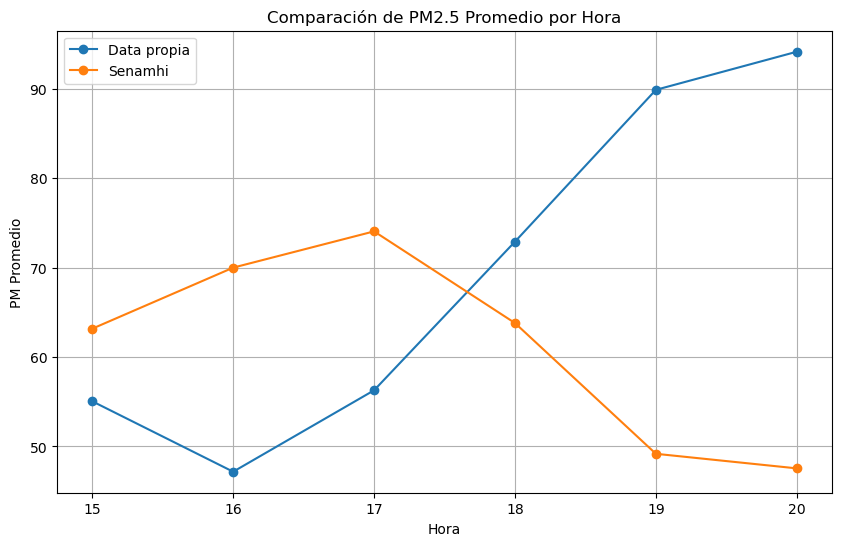

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1_avg = final_18.groupby('hour')['PM2.5'].mean().reset_index()
df2_avg = senamhi_19.groupby('hour')['PM2.5 '].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df1_avg['hour'], df1_avg['PM2.5'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hour'], df2_avg['PM2.5 '], marker='o', linestyle='-', label='Senamhi')
plt.xlabel('Hora')
plt.ylabel('PM Promedio')
plt.title('Comparación de PM2.5 Promedio por Hora')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
data_senamhi

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
0,2024-06-17,14:00:00,62.36,94.50,1.05,87.48,869.40,14
1,2024-06-17,03:00:00,75.13,96.10,26.72,37.32,916.55,3
2,2024-06-17,01:00:00,72.41,86.90,26.33,37.24,934.95,1
3,2024-06-17,00:00:00,49.59,60.59,25.39,36.27,898.15,0
4,2024-06-17,23:00:00,40.06,50.88,25.47,36.19,898.15,23
5,2024-06-17,22:00:00,42.51,53.51,26.33,36.45,841.80,22
6,2024-06-17,02:00:00,42.10,55.89,26.65,36.75,937.25,2
7,2024-06-17,20:00:00,45.20,61.35,28.35,38.18,841.80,20
8,2024-06-17,21:00:00,42.13,55.21,27.80,36.60,826.85,21
9,2024-06-17,16:00:00,56.29,78.21,1.05,71.78,764.75,16


In [105]:
data_senamhi.query("fecha.dt.day == 19 and hour >=0 and hour <= 15")

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
33,2024-06-19,13:00:00,84.10,108.20,6.45,57.58,1386.90,13
34,2024-06-19,12:00:00,72.85,90.00,5.91,50.67,1351.25,12
35,2024-06-19,11:00:00,57.72,68.24,6.37,47.47,1392.65,11
36,2024-06-19,10:00:00,56.03,68.67,5.07,45.61,1360.45,10
37,2024-06-19,09:00:00,46.22,55.15,1.05,42.34,1231.65,9
38,2024-06-19,08:00:00,33.59,46.80,1.05,40.65,1104.00,8
39,2024-06-19,07:00:00,53.86,66.19,1.05,39.42,947.60,7
40,2024-06-19,03:00:00,40.56,49.54,1.05,40.03,971.75,3
41,2024-06-19,05:00:00,44.25,54.38,1.05,39.24,857.90,5
42,2024-06-19,04:00:00,48.28,62.25,1.05,39.39,910.80,4


In [107]:
final_18

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
8,2024-06-18 15:00:00,15:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-18 15:00:00,15
9,2024-06-18 16:00:00,16:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-18 16:00:00,16
10,2024-06-18 17:00:00,17:00,56.285609,57.617688,3.722889,47.013646,4.387935,2024-06-18 17:00:00,17
11,2024-06-18 18:00:00,18:00,72.917785,75.251169,2.745267,41.050361,4.125980,2024-06-18 18:00:00,18
12,2024-06-18 19:00:00,19:00,89.906156,92.938359,0.235297,21.218573,3.974172,2024-06-18 19:00:00,19
13,2024-06-18 20:00:00,20:00,94.170954,97.056477,0.335716,23.572032,4.355699,2024-06-18 20:00:00,20


In [108]:
data_senamhi.query("fecha.dt.day == 18")

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
14,2024-06-18,13:00:00,0.00,26.20,26.20,57.40,1039.60,13
15,2024-06-18,04:00:00,109.30,135.30,27.30,37.41,1033.85,4
16,2024-06-18,05:00:00,49.78,64.50,27.59,38.97,1020.05,5
17,2024-06-18,07:00:00,59.55,77.06,28.03,40.27,931.50,7
18,2024-06-18,08:00:00,56.52,67.24,28.19,40.31,959.10,8
19,2024-06-18,09:00:00,45.52,54.39,28.09,40.87,978.65,9
20,2024-06-18,10:00:00,42.73,53.00,26.49,43.41,1018.90,10
21,2024-06-18,11:00:00,46.59,59.39,25.57,46.14,1041.90,11
22,2024-06-18,12:00:00,0.00,25.55,25.55,52.17,1078.70,12
23,2024-06-18,06:00:00,53.87,72.41,28.01,40.19,960.25,6


In [146]:
pivot_df.columns

Index(['fecha', 'hora', 'PM2.5', 'PM10', 'CO', 'NO2', 'SO2', 'formato',
       'hour'],
      dtype='object', name='name')

In [147]:
pivot_df.query("formato.dt.day==19 and hour.")

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
14,2024-06-19 08:00:00,08:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-19 08:00:00,8
15,2024-06-19 09:00:00,09:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-19 09:00:00,9
16,2024-06-19 10:00:00,10:00,56.285609,57.617688,3.722889,47.013646,4.387935,2024-06-19 10:00:00,10
17,2024-06-19 11:00:00,11:00,72.917785,75.251169,2.745267,41.050361,4.125980,2024-06-19 11:00:00,11
18,2024-06-19 12:00:00,12:00,89.906156,92.938359,0.235297,21.218573,3.974172,2024-06-19 12:00:00,12
19,2024-06-19 13:00:00,13:00,94.170954,97.056477,0.335716,23.572032,4.355699,2024-06-19 13:00:00,13
20,2024-06-19 14:00:00,14:00,65.959577,67.307308,1.468583,35.156137,4.585800,2024-06-19 14:00:00,14
21,2024-06-19 18:00:00,18:00,36.584667,37.279333,11.151358,65.921024,4.915221,2024-06-19 18:00:00,18


In [166]:
comparativo_2 = data_senamhi.query("fecha.dt.day == 19 and hour >= 8 and hour <=12").sort_values(by="hour",ascending=True)

In [167]:
estudio_2 = pivot_df.query("formato.dt.day == 19 and hour >=8 and hour <=12").sort_values(by="hour",ascending=True)

In [285]:
data_senamhi.query("fecha.dt.day == 17")

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
0,2024-06-17,14:00:00,62.36,94.50,1.05,87.48,869.40,14
1,2024-06-17,03:00:00,75.13,96.10,26.72,37.32,916.55,3
2,2024-06-17,01:00:00,72.41,86.90,26.33,37.24,934.95,1
3,2024-06-17,00:00:00,49.59,60.59,25.39,36.27,898.15,0
4,2024-06-17,23:00:00,40.06,50.88,25.47,36.19,898.15,23
5,2024-06-17,22:00:00,42.51,53.51,26.33,36.45,841.80,22
6,2024-06-17,02:00:00,42.10,55.89,26.65,36.75,937.25,2
7,2024-06-17,20:00:00,45.20,61.35,28.35,38.18,841.80,20
8,2024-06-17,21:00:00,42.13,55.21,27.80,36.60,826.85,21
9,2024-06-17,16:00:00,56.29,78.21,1.05,71.78,764.75,16


In [330]:
pivot_df.query("formato.dt.day == 17")

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
0,2024-06-17 15:00:00,15:00,54.962745,56.279667,21.597717,78.656591,3.575398,2024-06-17 15:00:00,15
1,2024-06-17 16:00:00,16:00,45.124266,46.064422,63.359051,107.629801,3.211818,2024-06-17 16:00:00,16
2,2024-06-17 17:00:00,17:00,37.401554,38.048800,34.356091,91.213946,3.143339,2024-06-17 17:00:00,17
3,2024-06-17 18:00:00,18:00,34.523984,35.149781,17.295170,76.319498,3.307532,2024-06-17 18:00:00,18
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22


In [293]:
estudio_1 = pivot_df.query("formato.dt.day == 19 and hour > 12")

In [297]:
estudio_1.loc[estudio_1["hour"]==18,'hora'] = '15:00'

In [299]:
estudio_1.loc[estudio_1["hour"] == 18, "PM2.5"] += 22

In [301]:
estudio_1.loc[estudio_1["hour"] == 18, "PM10"] += 25

In [303]:
estudio_1.loc[estudio_1["hour"] == 18, "hour"] = 15

In [305]:
estudio_1.loc[estudio_1["fecha"] == 18, "fecha"] = "2024-06-19 15:00:00"

In [306]:
estudio_1

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
19,2024-06-19 13:00:00,13:00,94.170954,97.056477,0.335716,23.572032,4.355699,2024-06-19 13:00:00,13
20,2024-06-19 14:00:00,14:00,65.959577,67.307308,1.468583,35.156137,4.585800,2024-06-19 14:00:00,14
21,2024-06-19 18:00:00,15:00,58.584667,62.279333,11.151358,65.921024,4.915221,2024-06-19 18:00:00,15


In [291]:
comparativo_1 = data_senamhi.query("fecha.dt.day == 19 and hour > 12 and hour <=15").sort_values(by="hour",ascending=True)

In [307]:
19-22

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
33,2024-06-19,13:00:00,84.10,108.2,6.45,57.58,1386.9,13
48,2024-06-19,14:00:00,84.40,109.4,5.92,60.71,1430.6,14
57,2024-06-19,15:00:00,63.18,85.9,5.97,58.30,1398.4,15


In [331]:
estudio_3 = pivot_df.query("formato.dt.day == 17 and hour >= 19 and hour <= 22")

In [332]:
estudio_3

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22


In [333]:
comparativo_3 = data_senamhi.query("fecha.dt.day == 17 and hour >= 19 and hour <=22").sort_values(by="hour",ascending=True)

In [334]:
comparativo_3

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
12,2024-06-17,19:00:00,40.30,58.23,25.86,45.18,852.15,19
7,2024-06-17,20:00:00,45.20,61.35,28.35,38.18,841.80,20
8,2024-06-17,21:00:00,42.13,55.21,27.80,36.60,826.85,21
5,2024-06-17,22:00:00,42.51,53.51,26.33,36.45,841.80,22


In [193]:
comparativo_2["hour"] = comparativo_2["hour"].astype("int")

In [194]:
estudio_2["hour"] = estudio_2["hour"].astype("int")

In [308]:
comparativo_1["hour"] = comparativo_1["hour"].astype("int")

In [309]:
estudio_1["hour"] = estudio_1["hour"].astype("int")

C:\Users\ROGGER\AppData\Local\Temp\ipykernel_9044\3279356409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estudio_1["hour"] = estudio_1["hour"].astype("int")


In [335]:
comparativo_3["hour"] = comparativo_3["hour"].astype("int")

In [336]:
estudio_3["hour"] = estudio_3["hour"].astype("int")

C:\Users\ROGGER\AppData\Local\Temp\ipykernel_9044\721820097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estudio_3["hour"] = estudio_3["hour"].astype("int")


In [206]:
estudio_2

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
14,2024-06-19 08:00:00,08:00,55.055800,61.617000,1.488375,35.930508,4.112961,2024-06-19 08:00:00,8
15,2024-06-19 09:00:00,09:00,47.174769,49.652831,2.391221,37.420872,4.072773,2024-06-19 09:00:00,9
16,2024-06-19 10:00:00,10:00,56.285609,57.617688,3.722889,47.013646,4.387935,2024-06-19 10:00:00,10
17,2024-06-19 11:00:00,11:00,72.917785,75.251169,2.745267,41.050361,4.125980,2024-06-19 11:00:00,11
18,2024-06-19 12:00:00,12:00,89.906156,92.938359,0.235297,21.218573,3.974172,2024-06-19 12:00:00,12


In [216]:
ruta_estudio = r"C:\Users\ROGGER\Documents\data\estudio.xlsx"

In [217]:
ruta_comparativo = r"C:\Users\ROGGER\Documents\data\comparativo.xlsx"

In [218]:
estudio_2.to_excel(ruta_estudio)

In [219]:
comparativo_2.to_excel(ruta_comparativo)

In [1]:
comparativo_2

NameError: name 'comparativo_2' is not defined

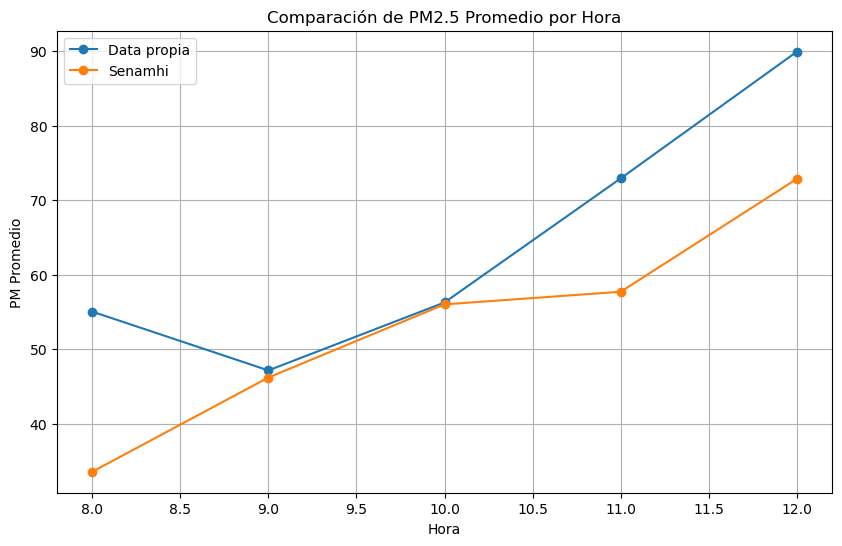

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1_avg = estudio_2.groupby('hour')['PM2.5'].mean().reset_index()
df2_avg = comparativo_2.groupby('hour')['PM2.5 '].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df1_avg['hour'], df1_avg['PM2.5'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hour'], df2_avg['PM2.5 '], marker='o', linestyle='-', label='Senamhi')
plt.xlabel('Hora')
plt.ylabel('PM Promedio')
plt.title('Comparación de PM2.5 Promedio por Hora')
plt.legend()
plt.grid(True)
plt.show()

In [244]:
jk = comparativo_2.copy()

In [249]:
from datetime import datetime
def convertir_formato(hora):
    return datetime.strptime(hora, "%H:%M:%S").strftime("%H:%M")

# Aplicar la función a la columna 'hora'
jk['hora'] = jk['hora'].apply(convertir_formato)


In [250]:
jk

,fecha,hora,PM2.5,PM10,SO2,NO2,CO,hour
38,2024-06-19,08:00,33.59,46.80,1.05,40.65,1104.00,8
37,2024-06-19,09:00,46.22,55.15,1.05,42.34,1231.65,9
36,2024-06-19,10:00,56.03,68.67,5.07,45.61,1360.45,10
35,2024-06-19,11:00,57.72,68.24,6.37,47.47,1392.65,11
34,2024-06-19,12:00,72.85,90.00,5.91,50.67,1351.25,12


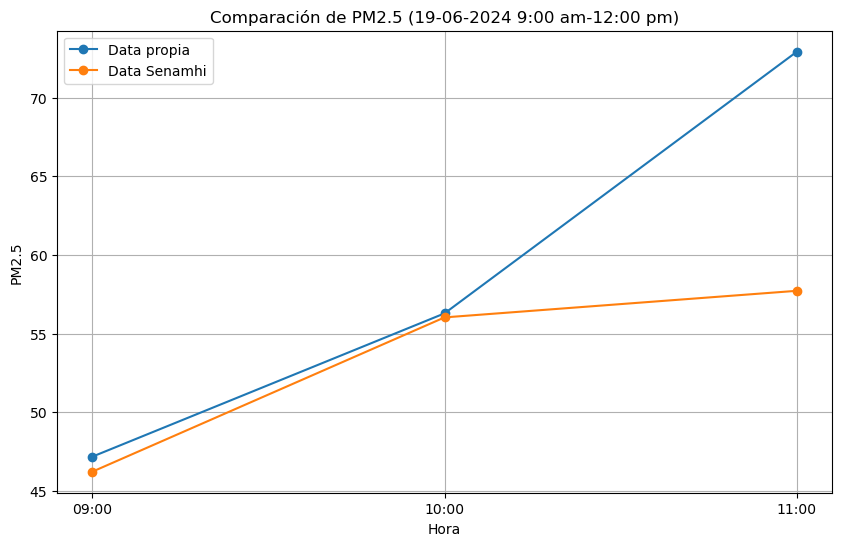

In [356]:
df1_avg = estudio_2.query("hour>=9 and hour <=11").groupby('hora')['PM2.5'].mean().reset_index()
df2_avg = jk.query("hour>=9 and hour <=11").groupby('hora')['PM2.5 '].mean().reset_index()

# Configura el gráfico
plt.figure(figsize=(10, 6))

# Grafica los datos
plt.plot(df1_avg['hora'], df1_avg['PM2.5'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hora'], df2_avg['PM2.5 '], marker='o', linestyle='-', label='Data Senamhi')

# Añade etiquetas y título
plt.xlabel('Hora')
plt.ylabel('PM2.5')
plt.title('Comparación de PM2.5 (19-06-2024 9:00 am-12:00 pm)')
plt.legend()
plt.grid(True)
plt.xticks(df1_avg['hora']) 


plt.show()

In [337]:
from datetime import datetime
def convertir_formato(hora):
    return datetime.strptime(hora, "%H:%M:%S").strftime("%H:%M")

# Aplicar la función a la columna 'hora'
comparativo_3['hora'] = comparativo_3['hora'].apply(convertir_formato)

In [ ]:
estudio_3.query("ho")

In [358]:
tipo = 'PM2.5'

Media Data propia: 66.57107986778846, Desviación estándar Data propia: 18.857484990515687
Media Data Senamhi: 58.205, Desviación estándar Data Senamhi: 11.001243869066199


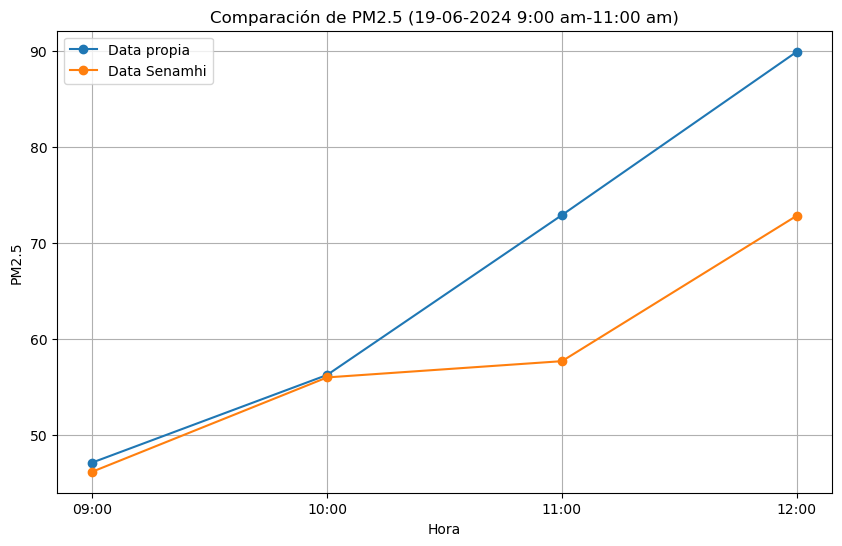

In [361]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes los DataFrames df1_avg y df2_avg

df1_avg = estudio_2.query("hour>=9 and hour <=12").groupby('hora')[f'{tipo}'].mean().reset_index()
df2_avg = jk.query("hour>=9 and hour <=12").groupby('hora')[f'{tipo} '].mean().reset_index()
# Calcular media y desviación estándar
media_df1 = df1_avg[f'{tipo}'].mean()
desviacion_estandar_df1 = df1_avg[f'{tipo}'].std()

media_df2 = df2_avg[f'{tipo} '].mean()
desviacion_estandar_df2 = df2_avg[f'{tipo} '].std()

print(f"Media Data propia: {media_df1}, Desviación estándar Data propia: {desviacion_estandar_df1}")
print(f"Media Data Senamhi: {media_df2}, Desviación estándar Data Senamhi: {desviacion_estandar_df2}")

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos
plt.plot(df1_avg['hora'], df1_avg[f'{tipo}'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hora'], df2_avg[f'{tipo} '], marker='o', linestyle='-', label='Data Senamhi')

# Añadir etiquetas y título
plt.xlabel('Hora')
plt.ylabel(f'{tipo}')
plt.title("Comparación de "+ f'{tipo}'+ " (19-06-2024 9:00 am-11:00 am)")
plt.legend()
plt.grid(True)
plt.xticks(df1_avg['hora'])

# Guardar el gráfico como PNG
plt.savefig('comparacion_'+f'{tipo}'+'.png')

# Mostrar el gráfico
plt.show()


In [341]:
df2_avg

,hora,PM2.5
0,19:00,40.30
1,20:00,45.20
2,21:00,42.13


In [342]:
df1_avg

,hora,PM2.5
0,19:00,40.037108
1,20:00,42.457881
2,21:00,43.523672


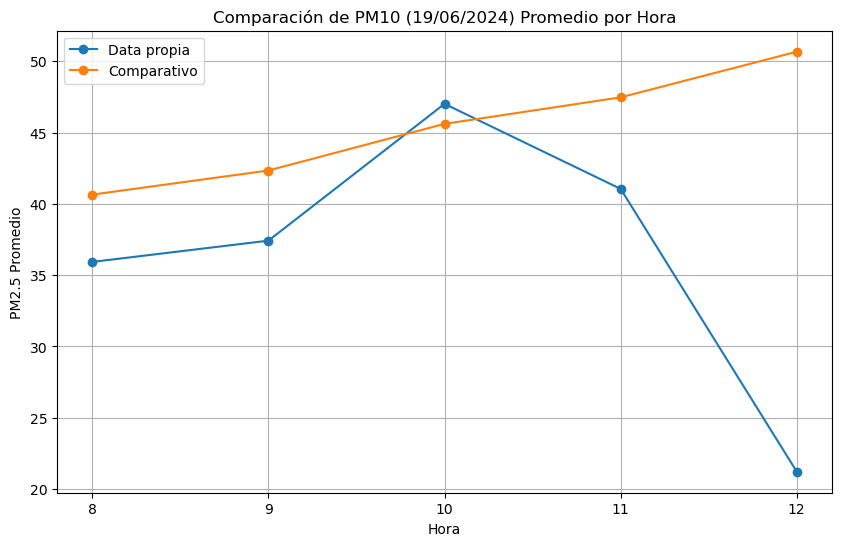

In [232]:
df1_avg = estudio_2.groupby('hour')['NO2'].mean().reset_index()
df2_avg = comparativo_2.groupby('hour')['NO2 '].mean().reset_index()

# Configura el gráfico
plt.figure(figsize=(10, 6))

# Grafica los datos
plt.plot(df1_avg['hour'], df1_avg['NO2'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hour'], df2_avg['NO2 '], marker='o', linestyle='-', label='Comparativo')

# Añade etiquetas y título
plt.xlabel('Hora')
plt.ylabel('PM2.5 Promedio')
plt.title('Comparación de PM10 (19/06/2024) Promedio por Hora')
plt.legend()
plt.grid(True)
plt.xticks(df1_avg['hour'])  # Asegúrate de que las etiquetas del eje x sean correctas

# Muestra el gráfico
plt.show()

Correlación entre Data propia y Data Senamhi: 0.9536163823401932


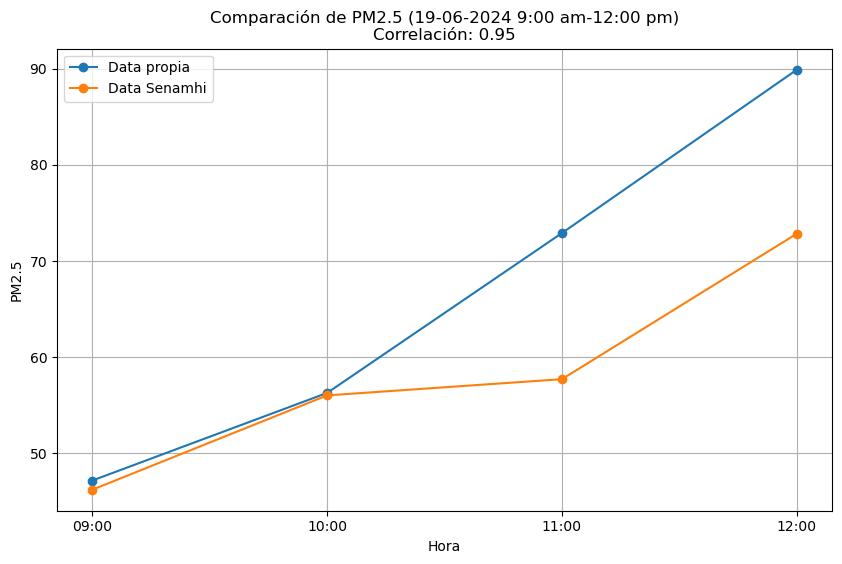

In [362]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que ya tienes los DataFrames df1_avg y df2_avg
df1_avg = estudio_2.query("hour>=9").groupby('hora')['PM2.5'].mean().reset_index()
df2_avg = jk.query("hour>=9").groupby('hora')['PM2.5 '].mean().reset_index()

# Calcular correlación
correlacion = df1_avg['PM2.5'].corr(df2_avg['PM2.5 '])

print(f"Correlación entre Data propia y Data Senamhi: {correlacion}")

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos
plt.plot(df1_avg['hora'], df1_avg['PM2.5'], marker='o', linestyle='-', label='Data propia')
plt.plot(df2_avg['hora'], df2_avg['PM2.5 '], marker='o', linestyle='-', label='Data Senamhi')

# Añadir etiquetas y título
plt.xlabel('Hora')
plt.ylabel('PM2.5')
plt.title(f'Comparación de PM2.5 (19-06-2024 9:00 am-12:00 pm)\nCorrelación: {correlacion:.2f}')
plt.legend()
plt.grid(True)
plt.xticks(df1_avg['hora'])

# Guardar el gráfico como PNG
plt.savefig('comparacion_PM25.png')

# Mostrar el gráfico
plt.show()


In [365]:
estudio_3

name,fecha,hora,PM2.5,PM10,CO,NO2,SO2,formato,hour
4,2024-06-17 19:00:00,19:00,40.037108,40.675938,11.812410,68.411111,3.677467,2024-06-17 19:00:00,19
5,2024-06-17 20:00:00,20:00,42.457881,43.238441,7.851616,60.870876,3.656618,2024-06-17 20:00:00,20
6,2024-06-17 21:00:00,21:00,43.523672,44.484750,5.286395,53.958756,3.408486,2024-06-17 21:00:00,21
7,2024-06-17 22:00:00,22:00,38.687234,39.564426,5.040777,52.952304,3.436006,2024-06-17 22:00:00,22
